In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
os.environ['https_proxy'] = 'http://10.16.35.10:13390' 

import torch
from torch import nn
import torch.nn.functional as F

import sys
sys.path.append('..')
from prior_networks import UViT_Clip
from prior_pipe import PriorPipe
from dataset import *
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load prior diffusion

In [2]:
diffusion_prior = UViT_Clip(embed_dim=512, num_heads=8, mlp_ratio=4)
# number of parameters
sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad)
pipe = PriorPipe(diffusion_prior, device=device)
# load pretrained model
model_name = 'uvit_vice_pred_imagenet' 
path = f'../ckpts/{model_name}'
pipe.diffusion_prior.load_state_dict(torch.load(f'{path}.pt'))
# pipe.ema.load_state_dict(torch.load(f'{path}_ema.pt'))

<All keys matched successfully>

# load sd

In [3]:
# extract image features
from diffusers.utils import load_image
from IPython.display import Image, display
from customized_pipe import Generator4Embeds, encode_image
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
import torch

feature_extractor = CLIPImageProcessor()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter", 
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
).to("cuda")

pipe_image = Generator4Embeds(path='stabilityai/sdxl-turbo', num_inference_steps=4)
# pipe_image = Generator4Embeds(path='stabilityai/stable-diffusion-xl-base-1.0', num_inference_steps=25)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
pipe_image.pipe.feature_extractor = feature_extractor
pipe_image.pipe.image_encoder = image_encoder

In [5]:
from diffusers.schedulers import DDPMScheduler
scheduler = DDPMScheduler(
    thresholding=False,
    clip_sample=False,
)
pipe.scheduler = scheduler
print((
    pipe.scheduler.config.thresholding, 
    pipe.scheduler.config.sample_max_value, 
    pipe.scheduler.config.clip_sample,
    pipe.scheduler.config.clip_sample_range
))

(False, 1.0, False, 1.0)


# load concept encoder

In [6]:
# Load concept encoder
from networks import SimpleRegProb
# concept_encoder = MLPProb(1024, 42, l1=0.01).to(device)
concept_encoder = SimpleRegProb(1024, 42, l1=0).to(device)
path_save = os.path.join('../ckpts', 'emb_predict_SimpleReg.pt')
concept_encoder.load_state_dict(torch.load(path_save)['parameters'])

<All keys matched successfully>

In [8]:
from diffusers.utils import load_image, make_image_grid

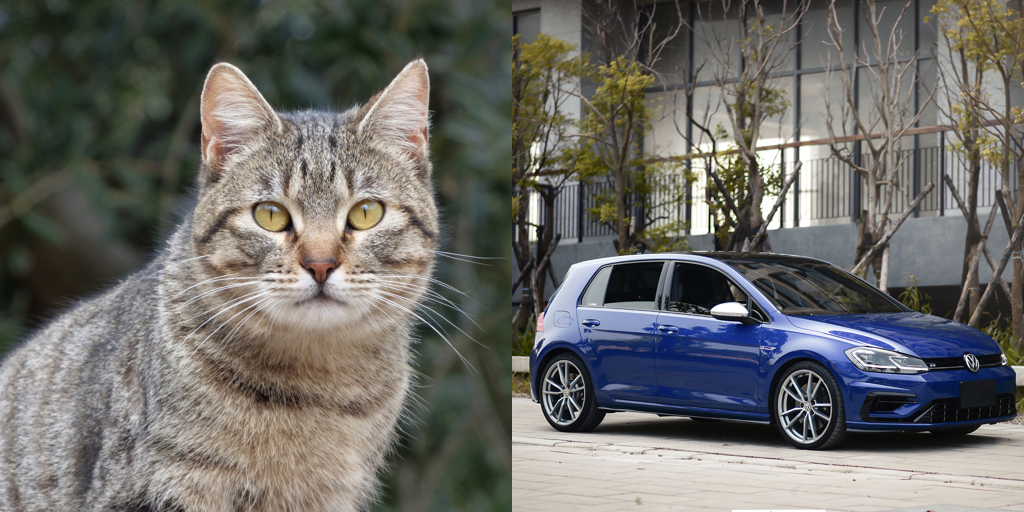

In [9]:
# extract a concept embedding
image_prompt = load_image("../images/cat.jpg")
image_prompt2 = load_image("../images/car.jpg")
# image_prompt = load_image("https://image-cdn.hypb.st/https%3A%2F%2Fhypebeast.com%2Fwp-content%2Fblogs.dir%2F6%2Ffiles%2F2022%2F10%2Fstudio-ghibli-hayao-miyazaki-new-movie-almost-finished-1.jpg?cbr=1&q=90")
from IPython.display import display
image_embeds = encode_image([image_prompt, image_prompt2], image_encoder, feature_extractor)
concept_embeds = concept_encoder(image_embeds.float())   
display(make_image_grid([image_prompt, image_prompt2], rows=1, cols=2, resize=512))

# Experiments

## consistent and diversity

### single concept

In [10]:
num = 4
concept_edited = ['cotton clothing']
ind_concept_edited = [label_concept.index(c) for c in concept_edited]
# set value to a+b*torch.rand(1) or a+b*torch.randn(1) to keep diversity for single concept
values = torch.tensor([
    [1. + 1*torch.rand(1)] 
    for i in range(num)
], device=device)
print('Concept values:', values)

seed_value = 1
generators = [torch.Generator(device=device).manual_seed(1) for _ in range(num)]
seed_values = torch.randint(10000, (num, ), generator=torch.Generator(device=device).manual_seed(seed_value), device=device)
print('Seed values:', seed_values)
for seed, generator in zip(seed_values, generators):
    generator.manual_seed(seed.item())

from guidance_set import get_loss_dim, fns_collector
# Adjust loss functions to handle batched input
loss_dim = get_loss_dim(concept_encoder, ind_concept_edited, values)

loss_func = fns_collector(
    fns=[
        loss_dim, 
        # loss_smooth,
        # loss_similarity,
    ],
    scales=[1,]
)


# Generate all embeddings in one pass
h = pipe.generate_guidance(
    loss_fn=loss_func,
    num_inference_steps=50,
    num_resampling_steps=5,
    guidance_scale=0.5,
    generator=generators,
    use_ema=False,
    latent=None,
    strength=1,
    N=num,
    shape=(1024,)
)

# Generate all images in parallel
pipe_image.pipe.set_ip_adapter_scale(1)

images = pipe_image.generate(
    h.to(dtype=torch.float16),
    generator=generators,
)


Concept values: tensor([[1.2744],
        [1.4108],
        [1.1577],
        [1.4600]], device='cuda:0')
Seed values: tensor([4032, 6450, 5999,  127], device='cuda:0')


50it [00:05,  8.39it/s]
/home/weichen/miniconda3/envs/sd/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `_name_or_path` directly via 'StableDiffusionXLPipeline' object attribute is deprecated. Please access '_name_or_path' over 'StableDiffusionXLPipeline's config object instead, e.g. 'scheduler.config._name_or_path'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/4 [00:00<?, ?it/s]

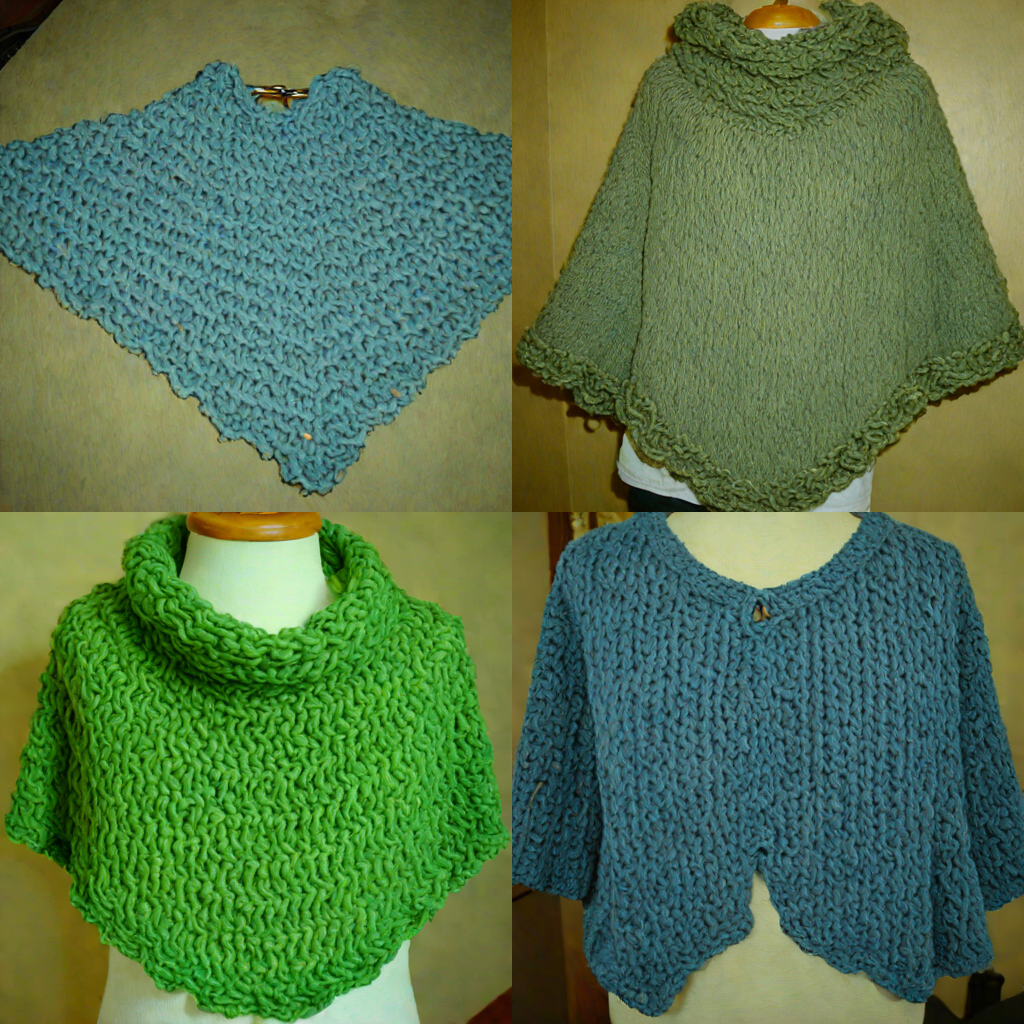

In [11]:
display(make_image_grid([*images], rows=2, cols=2, resize=512))

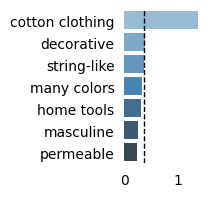

In [12]:
concept_embeds_h = concept_encoder(h.float()) 
concept_embeds = concept_embeds_h.mean(dim=0)
plot_bar(label_concept, concept_embeds.squeeze())

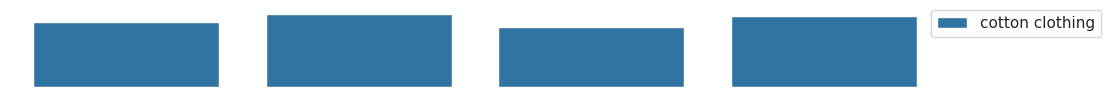

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

xticks = list(range(num))

# image_embeds_pred = encode_image(images, image_encoder, feature_extractor)
concept_embeds_h = concept_encoder(h.float()) 
# concept_embeds_pred = concept_encoder(image_embeds_pred.float()) 
# values of the concept edited across the batch
## (B, len(concept_dims))
values_gen = concept_embeds_h[:, ind_concept_edited].detach().cpu()
values_gen = values_gen.tolist()

# create df for barplot, with xticks, value and concept
df = pd.DataFrame({'xticks': [i for i in xticks for _ in range(1)], 'value': [i for v in values_gen for i in v], 'concept': concept_edited*num})

# 创建折线图
sns.set(style="whitegrid")  # 设置Seaborn样式

plt.figure(figsize=(12, 1.))

# 绘制折线图
ax = sns.barplot(x='xticks', y='value', hue='concept', data=df, palette="tab10")



sns.despine(left=True, bottom=True)  # 移除左边和底部的轴线和边框

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

plt.legend(bbox_to_anchor=(0.99,1), loc=2, borderaxespad=0.)
plt.show()

### multiple concepts

In [38]:
num = 4
concept_edited = ['wood', 'plant']
ind_concept_edited = [label_concept.index(c) for c in concept_edited]
# set value to a+b*torch.rand(1) to keep diversity for single concept
values = torch.tensor([
    [.6, 1.5] 
    for i in range(num)
], device=device)
print('Concept values:', values)

seed_value = 1
generators = [torch.Generator(device=device).manual_seed(1) for _ in range(num)]
seed_values = torch.randint(10000, (num, ), generator=torch.Generator(device=device).manual_seed(seed_value), device=device)
print('Seed values:', seed_values)
for seed, generator in zip(seed_values, generators):
    generator.manual_seed(seed.item())

# Adjust loss functions to handle batched input
loss_dim = get_loss_dim(concept_encoder, ind_concept_edited, values)

loss_func = fns_collector(
    fns=[
        loss_dim, 
        # loss_smooth,
        # loss_similarity,
    ],
    scales=[1,]
)


# Generate all embeddings in one pass
h = pipe.generate_guidance(
    loss_fn=loss_func,
    num_inference_steps=50,
    num_resampling_steps=5,
    guidance_scale=0.5,
    generator=generators,
    use_ema=False,
    latent=None,
    strength=1,
    N=num,
    shape=(1024,)
)

# Generate all images in parallel
pipe_image.pipe.set_ip_adapter_scale(1)

images = pipe_image.generate(
    h.to(dtype=torch.float16),
    generator=generators,
)


Concept values: tensor([[0.6000, 1.5000],
        [0.6000, 1.5000],
        [0.6000, 1.5000],
        [0.6000, 1.5000]], device='cuda:0')
Seed values: tensor([4032, 6450, 5999,  127], device='cuda:0')


50it [00:05,  9.85it/s]
/home/weichen/miniconda3/envs/sd/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `_name_or_path` directly via 'StableDiffusionXLPipeline' object attribute is deprecated. Please access '_name_or_path' over 'StableDiffusionXLPipeline's config object instead, e.g. 'scheduler.config._name_or_path'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/4 [00:00<?, ?it/s]

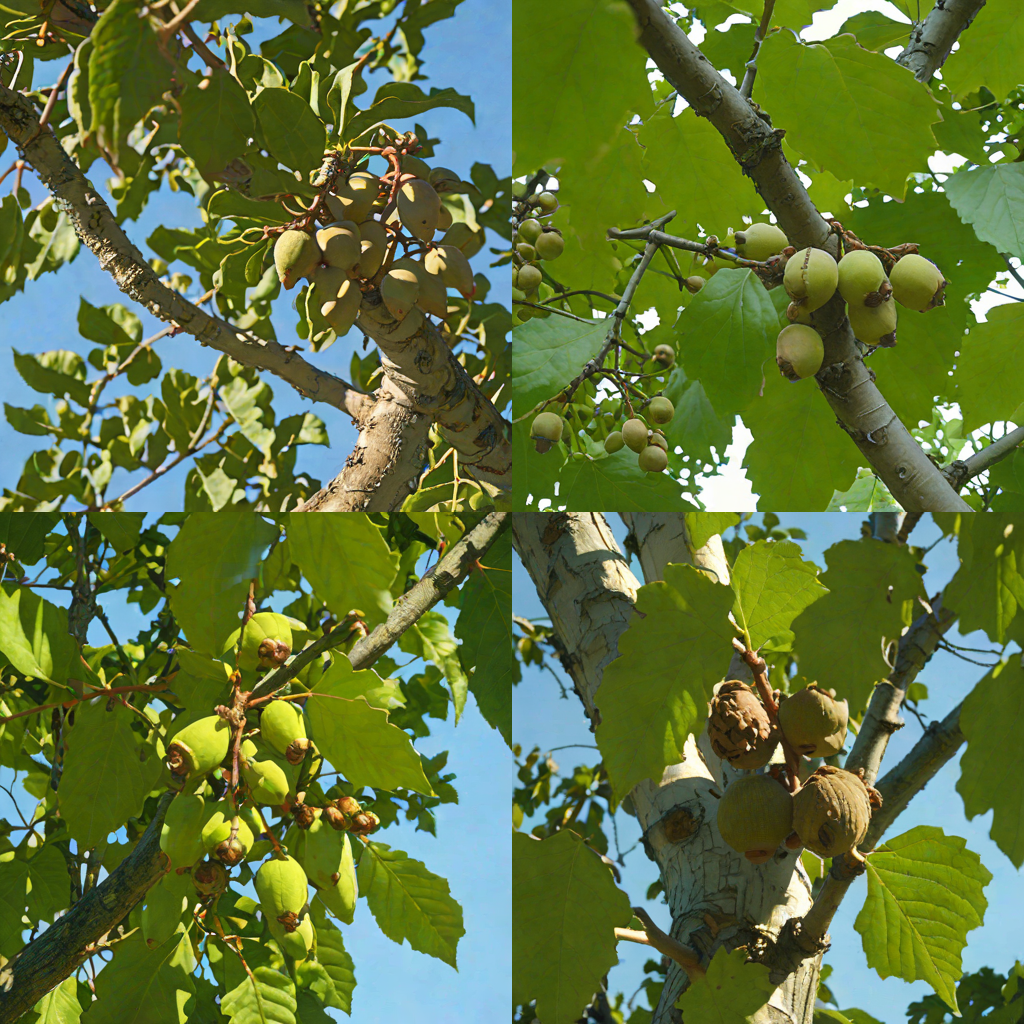

In [39]:
display(make_image_grid([*images], rows=2, cols=2, resize=512))

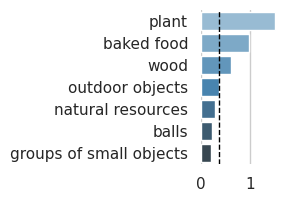

In [40]:
concept_embeds_h = concept_encoder(h.float()) 
concept_embeds = concept_embeds_h.mean(dim=0)
plot_bar(label_concept, concept_embeds.squeeze())